In [29]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

#-----
from torch.utils.tensorboard import SummaryWriter

# Enable interactive plot

#%matplotlib notebook
plt.style.use('seaborn')

## Loading dataset

In [2]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, data, targets, total_data = 450000, transform=True):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.total_data = total_data
        
    def __getitem__(self, index):
        
        total_data = self.total_data  # 198 data by file, 1000 files(from 0 to 999), total data: 198*100 = 19800
        
        if index > total_data:
            print("Error, this data does not exist")
        else:
            index_data = index #(index//199)%199  # because there 198 data per file
            index_t = 0#(index-199)%199
            
            # Input data: Wavepacket real and imaginary part + Potential at time t
            x_r = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t)+'-wave.npy')).real
            x_i = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t)+'-wave.npy')).imag
            x_p = np.load(self.data+str(index_data)+'/Potential/'+str(index_t)+'-potential.npy')
            # Output data: Wavepacket real and imaginary part at time t+1*step
            y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+1)+'-wave.npy')).real
            y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+1)+'-wave.npy')).imag
        
            x = np.concatenate((x_r, x_i, x_p))  # flat array form

            y = np.concatenate((y_r, y_i))  # flat array form
        
            if self.transform:
                x = torch.from_numpy(x)
                y = torch.from_numpy(y)
        
            return x, y
    
    def __len__(self):
        
        
        return self.total_data



In [3]:
path = '../../NewData/data'  # Directory where are saving our data

dataset = Propagator_Dataset(data=path, targets=path, transform=True)
batch_size = 12
validation_split = .1  #9:1 ratio
shuffle_dataset = True
random_seed= 42

In [4]:
dataset_size = len(dataset)
print('Total of data ', dataset_size)

Total of data  450000


In [5]:
# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)


In [6]:
print(f"Total of train samples: {len(train_sampler)}")
print(f"Total of test samples: {len(test_sampler)}")

Total of train samples: 405000
Total of test samples: 45000


In [7]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

## Visualization and shape of data

In [8]:
for X, y in train_loader:
    print("Train data:")
    print(f"Shape of X in train loader: {X.shape}")
    print(f"Shape of y in train loader: {y.shape} {y.dtype}")
    break
    
for X, y in test_loader:
    print("\nTest data:")
    print(f"Shape of X in test loader: {X.shape}")
    print(f"Shape of y in test loader: {y.shape} {y.dtype}")
    break
    
    

Train data:
Shape of X in train loader: torch.Size([12, 96])
Shape of y in train loader: torch.Size([12, 64]) torch.float64

Test data:
Shape of X in test loader: torch.Size([12, 96])
Shape of y in test loader: torch.Size([12, 64]) torch.float64


<IPython.core.display.Javascript object>


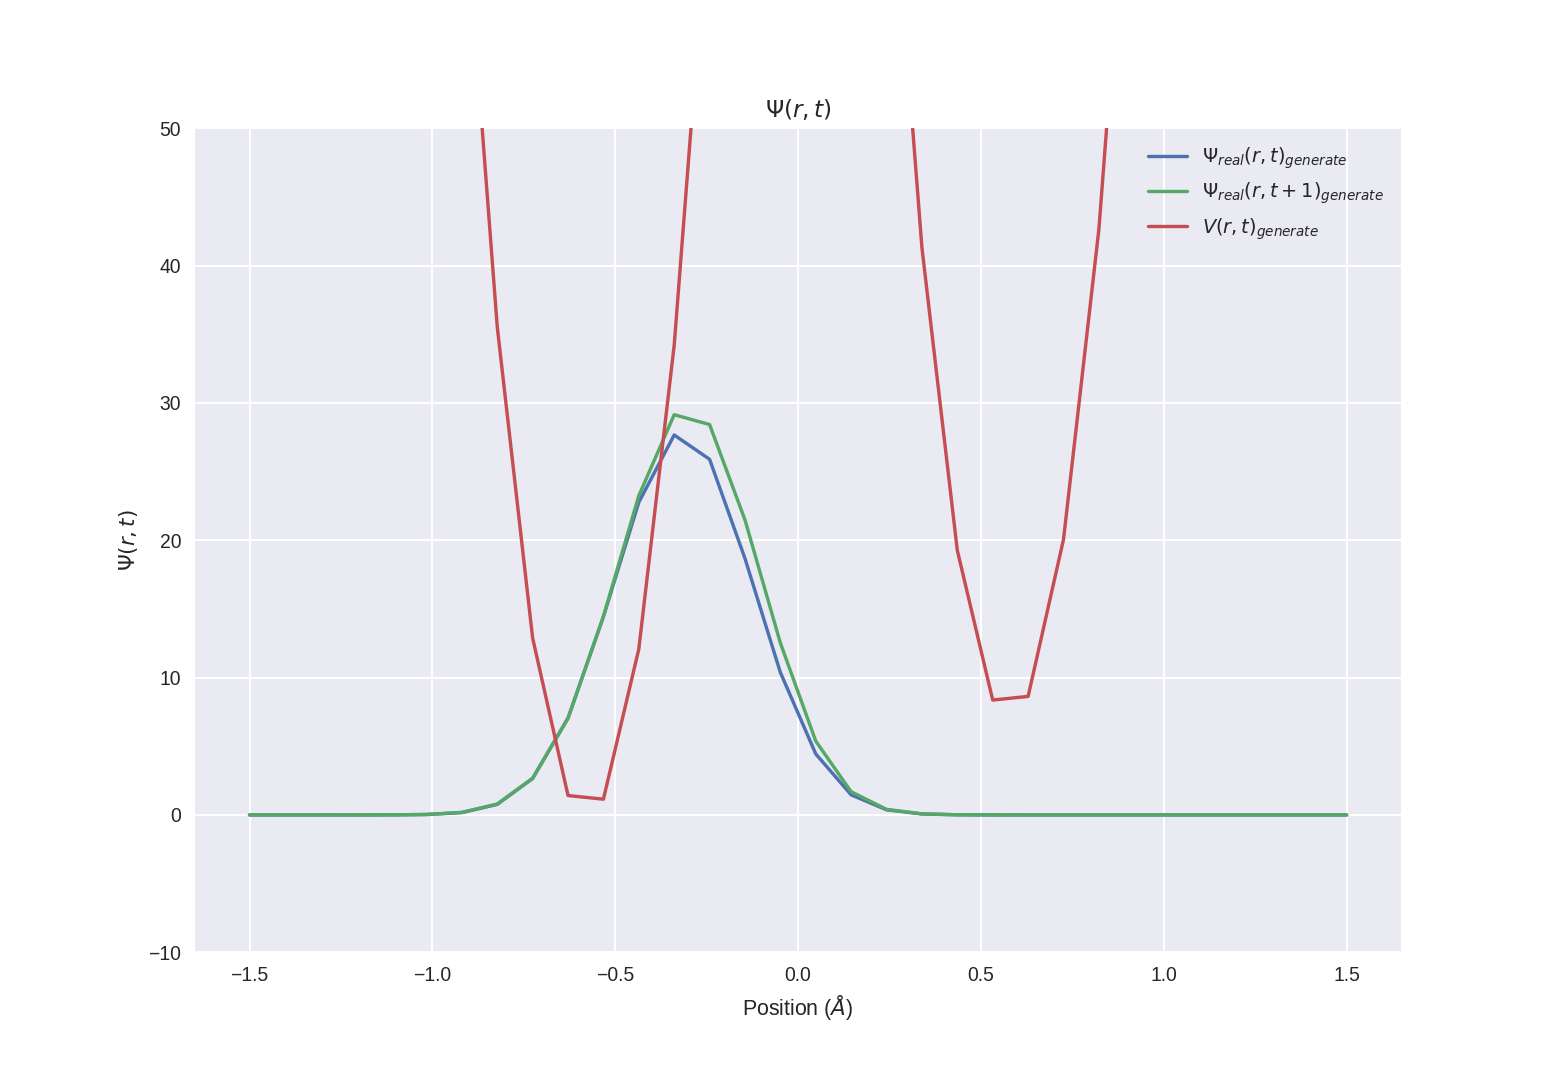

In [35]:
# Choose a random data
for X, y in train_loader:
    
    X_real_vis = X[0,0:32]
    X_imag_vis = X[0,32:64]
    X_pot_vis = X[0,64:96]
    
    y_real_vis = y[0,0:32]
    y_imag_vis = y[0,32:64]
    break
    
X_real_vis = X_real_vis.numpy()
y_real_vis = y_real_vis.numpy()
pot = X_pot_vis.numpy()
    
r_n = np.linspace(-1.5,1.5,32)
fig, ax = plt.subplots()
ax.set_title(r"$\Psi(r,t)$")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\Psi(r,t)$')
ax.set_ylim(-10,50)

# Lenght: au -> Angstroms
ax.plot(r_n, X_real_vis*30, label="$\Psi_{real}(r, t)_{generate}$")  #Escaled
ax.plot(r_n, y_real_vis*30, label="$\Psi_{real}(r, t+1)_{generate}$")  # Escaled
ax.plot(r_n, pot*(1/1.5936e-3), label="$V(r, t)_{generate}$")  # kcal/mol

ax.legend()
plt.show()
    

## Multilayer Perceptron model

In [13]:
device = "cpu"
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(96, 1024),
            nn.ReLU(),
            nn.ReLU(),
            nn.ReLU(),
            nn.Linear(1024, 64)
        )
        
    def forward(self, x):
        return self.layers(x)

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=96, out_features=1024, bias=True)
    (1): ReLU()
    (2): ReLU()
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=64, bias=True)
  )
)


In [ ]:
device = "cpu"
# Define model
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(96, 10204),
            nn.Tanh(),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(10204, 64)
        )
        
    def forward(self, x):
        return self.layers(x)

model1 = NeuralNetwork1().to(device)
print(model1)

In [14]:
writer = SummaryWriter()  # To use tensorboard

## Loss function & Optimizer

In [15]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

## Accuracy function

In [16]:
def S_overlap(Psi_true, Psi_ANN):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test
    Psi_ANN: Evolution of wavepacket predicted with the model
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article
    
    """
    S_tot = []
    angle_tot = []
    for j in range(batch_size):
        Psi_true_re = Psi_true[j,0:32]  # real part of wavepacket
        Psi_true_im = Psi_true[j,32:64]  # imaginary part of wavepacket
        Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1))
    
    
        Psi_ANN_re = Psi_ANN[j,0:32]  # realpart of wavepacket predicted
        Psi_ANN_im = -Psi_ANN[j,32:64]  # imaginary part of wavepacket predicted (- because conjugate)
        Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1))
        
        
        
        overlap = []
        for i in range(32):
            overlap.append(torch.tensor([Psi_A[i]*Psi_t[i]]))
        overl = torch.tensor(overlap)
        
        # Integrate over r (real integral + complex integral)
        # Simpson method in the grid r_n (angstroms -> au)
        r_n = np.linspace(-1.5,1.5,32)*(1/0.5291775)
        overl_real = overl.real.numpy()
        overl_imag = overl.imag.numpy()
    
        real_integ = integrate.simpson(overl_real, r_n)
        imag_integ = integrate.simpson(overl_imag, r_n)
    
        # Covert to phase and magnitude of the complex result
        S_tot.append(np.sqrt(real_integ**2 + imag_integ**2))
        angle_tot.append(np.arctan(imag_integ/real_integ))
        
    S = sum(S_tot)/batch_size
    angle = sum(angle_tot)/batch_size
    
    return S, angle

### Test of accuracy function
Two same vectors should give S=1 & and angle=0

In [17]:
for X, y in train_loader:
    S, angle = S_overlap(y,y)
    print(S)
    print(angle)
    break

1.0
1.9167405730809627e-18


Average of S and angle over a set

In [ ]:
# Test over test loader
correct1 = 0
for X, y in test_loader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    X, y = X.to(device), y.to(device)
    S, angle = S_overlap(y, y)  # Accuracy by equation (11) Main Article       
    correct1 += S
correct1 /= num_batches
print(f"Test Error: \n Accuracy: {(100*correct1):>0.1f}%\n")  # Should be 100% because y=y => main of |S| = 1


## Train & Test Loop

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)#len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            writer.add_scalar("Loss/train", loss, epoch)


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y, pred)  
            correctS += S
            correct_phase += angle
    test_loss /= num_batches
    correctS /= num_batches
    correct_phase /= num_batches
    writer.add_scalar('Accuracy Magnitude |S| /test', 100*correctS, epoch)  # Should be 100%
    writer.add_scalar('Accuracy phase /test', correct_phase, epoch)  # Should be 0
    

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

In [ ]:
epochs = 100
for epoch in range(42,epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
    
writer.flush()

## Saving the model

In [ ]:
torch.save(model, './NewData_MLP_1_91Epoch.pth')

## Loading a model

In [18]:
model = torch.load('NewData_MLP_1_91Epoch.pth')

In [20]:
#writer.add_graph(model,torch.from_numpy(X1_t).float())

In [ ]:
#from torchviz import make_dot
#out = model(torch.from_numpy(X1_t).float())
#make_dot(out)

## Inference: Density Evolution by NN

In [21]:
path_infe = '../../Data_Gaussian_Test/data'

In [22]:
onda_r = np.zeros((32,141))
onda_i = np.zeros((32,141))
pote = np.zeros((32,141))

densidad = np.zeros((32,141))

X = np.zeros((96,141))
for i in range(0,140,1):
    onda_r[:,i] = np.load('../../Data_Gaussian_Test/data0/Wavepacket/'+str(i)+'-wave.npy').real
    onda_i[:,i] = np.load('../../Data_Gaussian_Test/data0/Wavepacket/'+str(i)+'-wave.npy').imag
    pote[:,i] = np.load('../../Data_Gaussian_Test/data0/Potential/'+str(i)+'-potential.npy')
    
    X[:,i] = np.concatenate((onda_r[:,i],onda_i[:,i], pote[:,i]))
    densidad[:,i] = np.abs(np.vectorize(complex)(onda_r[:,i], onda_i[:,i]))**2
    

In [23]:
def trajectory_model(t, X_in):
    if t == 0:
        y1_pred = model(torch.from_numpy(X[:,0]).float())
        return y1_pred
    else:
        yt_pred = model(torch.cat((trajectory_model(t-1, X_in), torch.from_numpy(pote[:,t-1]).float()),0))
        return yt_pred

In [24]:
def density_model(y):
    
    y_r = y[0:32].detach().numpy()
    y_i = y[32:64].detach().numpy()
    
    y = np.vectorize(complex)(y_r,y_i)
    
    return (np.abs(y))**2

In [25]:
r_n = np.linspace(-1.5,1.5,32)

dens0 = density_model(trajectory_model(0, X[:,0]))
dens10 = density_model(trajectory_model(5, X[:,0]))
dens20 = density_model(trajectory_model(10, X[:,0]))
dens30 = density_model(trajectory_model(15, X[:,0]))
dens40 = density_model(trajectory_model(20, X[:,0]))
dens120 = density_model(trajectory_model(25, X[:,0]))


<IPython.core.display.Javascript object>


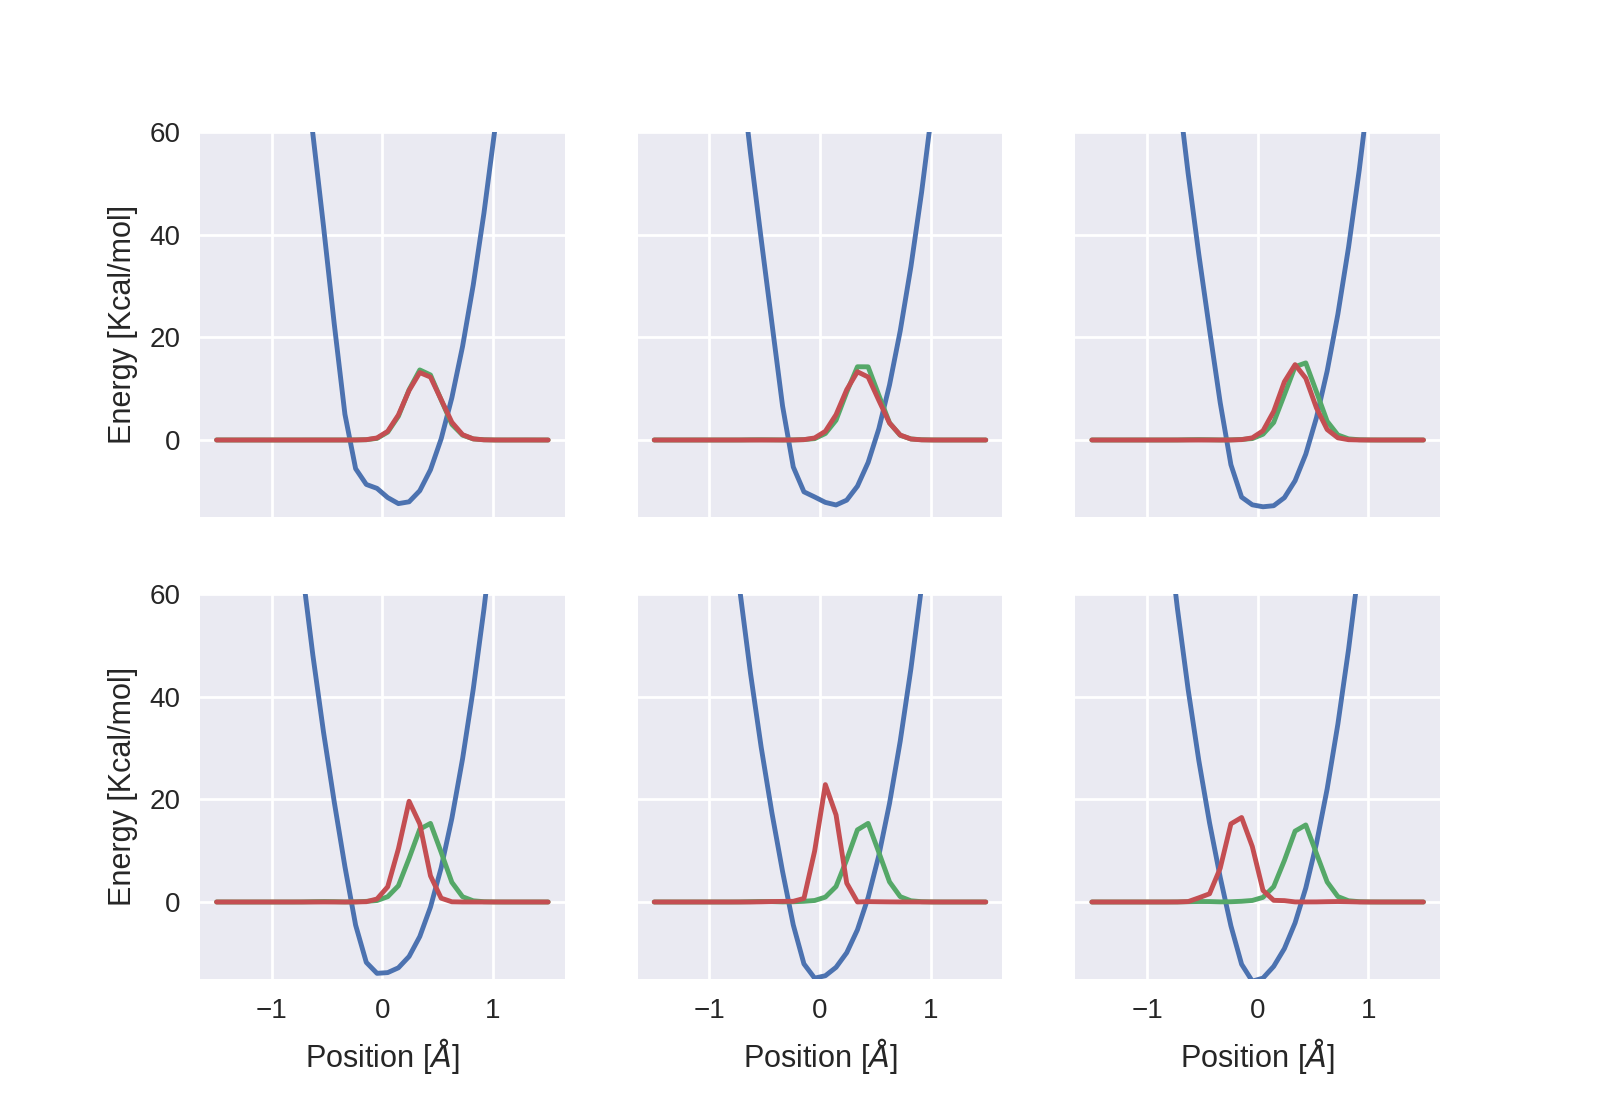

In [26]:
fig, axs = plt.subplots(2,3)


    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
axs[0,0].plot(r_n, pote[:,0]*(1/1.5936e-3), "-", label="0 fs")
axs[0,0].plot(r_n, dens0*10, label="$|\Psi_{ANN}(r, t=0)|^{2}$")
axs[0,0].plot(r_n, densidad[:,0]*10, label="$|\Psi_{True}(r, t=0)|^{2}$")


axs[0,1].plot(r_n, pote[:,5]*(1/1.5936e-3), "-", label="5 fs")
axs[0,1].plot(r_n, dens10*10, label="$|\Psi_{ANN}(r, t=50)|^{2}$")
axs[0,1].plot(r_n, densidad[:,6]*10, label="$|\Psi_{True}(r, t=5)|^{2}$")


axs[0,2].plot(r_n, pote[:,10]*(1/1.5936e-3), "-", label="10 fs")
axs[0,2].plot(r_n, dens20*(10), label="$|\Psi_{ANN}(r, t=10)|^{2}$")
axs[0,2].plot(r_n, densidad[:,11]*10, label="$|\Psi_{True}(r, t=10)|^{2}$")

axs[1,0].plot(r_n, pote[:,15]*(1/1.5936e-3), "-", label="15 fs")
axs[1,0].plot(r_n, dens30*(10), label="$|\Psi_{ANN}(r, t=15)|^{2}$")
axs[1,0].plot(r_n, densidad[:,16]*10, label="$|\Psi_{True}(r, t=15)|^{2}$")

axs[1,1].plot(r_n, pote[:,20]*(1/1.5936e-3), "-", label="20 fs")
axs[1,1].plot(r_n, dens40*(10), label="$|\Psi_{ANN}(r, t=20)|^{2}$")
axs[1,1].plot(r_n, densidad[:,21]*10, label="$|\Psi_{True}(r, t=20)|^{2}$")


axs[1,2].plot(r_n, pote[:,25]*(1/1.5936e-3), "-", label="25 fs")
axs[1,2].plot(r_n, dens120*(10), label="$|\Psi_{ANN}(r, t=120)|^{2}$")
axs[1,2].plot(r_n, densidad[:,26]*10, label="$|\Psi_{True}(r, t=25)|^{2}$")




for axr1 in axs:
    for axr11 in axr1:
        axr11.set_ylim([-15, 60])
        #axr11.legend()
        axr11.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

    

        
    
plt.show()